In [1]:
%matplotlib notebook

import numpy as np
import datetime

import os 
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from netCDF4 import Dataset, num2date
from pynextsim.netcdf_list import NetcdfList
import xarray as xr

import cartopy.crs as ccrs

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section

In [ ]:
path_in = "/cluster/projects/nn9624k/rheinlender/ERA5"
print(path_in)

ds = xr.open_dataset(path_in + '/ERA5_msl_y2013_daily.nc')   # sea level pressure for 2013

# convert units
with xr.set_options(keep_attrs=True):
    ds['msl'] = ds.msl / 100 
    ds.msl.attrs['units'] = 'hPa'

lat = ds.latitude.values
lon = ds.longitude.values

print(lon)
# select time-slice 
subset = ds.sel(time=slice('2013-01-01', '2013-03-20'))

date=subset['time']


In [ ]:
# quick plot
plt.close('all')
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))
ax.set_extent([-180, -60, 57, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
plot = ds.msl.sel(time='2013-01-01',longitude=slice(180, 240), latitude=slice(80, 60)).plot(cmap=plt.cm.coolwarm, 
                                          transform=ccrs.PlateCarree(), 
                                          cbar_kwargs={'orientation':'horizontal','shrink':0.9})

gridlines = ax.gridlines(draw_labels=True)
plt.show()


In [ ]:
# plot time series


mask=ds.msl.sel(longitude=slice(180, 240), latitude=slice(80, 60))
mask=mask.mean(["latitude", "longitude"])

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

mask.sel(time=slice('2013-01-01', '2013-03-20')).plot()

In [133]:
# Time series of surface winds

path_in = "/cluster/projects/nn9624k/rheinlender/ERA5"
print(path_in)

u10 = xr.open_dataset(path_in + '/ERA5_u10_y2013_daily.nc')   # zonal winds
v10 = xr.open_dataset(path_in + '/ERA5_v10_y2013_daily.nc')   # meridional winds

# select time slice
u10 = u10.sel(time=slice('2013-01-01', '2013-03-20'))
v10 = v10.sel(time=slice('2013-01-01', '2013-03-20'))

# Parse the full dataset to MEtPy
udata = u10.metpy.parse_cf()
vdata = v10.metpy.parse_cf()

# Define start and end points (lat/lon) for cross section:
start = ( 71.37558, -156.551204) #Point Barrow
end = ( 74.310828, -124.729037) #Banks Island

# Get the cross section
ucross = cross_section(udata, start, end)
vcross = cross_section(vdata, start, end)

print(ucross, vcross)


/cluster/projects/nn9624k/rheinlender/ERA5


Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


<xarray.Dataset>
Dimensions:    (index: 100, time: 79)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01T12:00:00 ... 2013-03-20T12:00:00
    crs        object Projection: latitude_longitude
    longitude  (index) float64 203.4 203.7 204.0 204.2 ... 234.5 234.9 235.3
    latitude   (index) float64 71.38 71.43 71.48 71.53 ... 74.3 74.3 74.31 74.31
  * index      (index) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    u10        (time, index) float64 -9.268 -9.366 -9.429 ... -5.231 -5.042
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Sep 10 14:11:00 2020: ncra --mro -d time,,,24,24 /clust...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne... <xarray.Dataset>
Dimensions:    (index: 100, time: 79)
Coordinates:
  * time       (time) datetime64[ns] 20

<IPython.core.display.Javascript object>


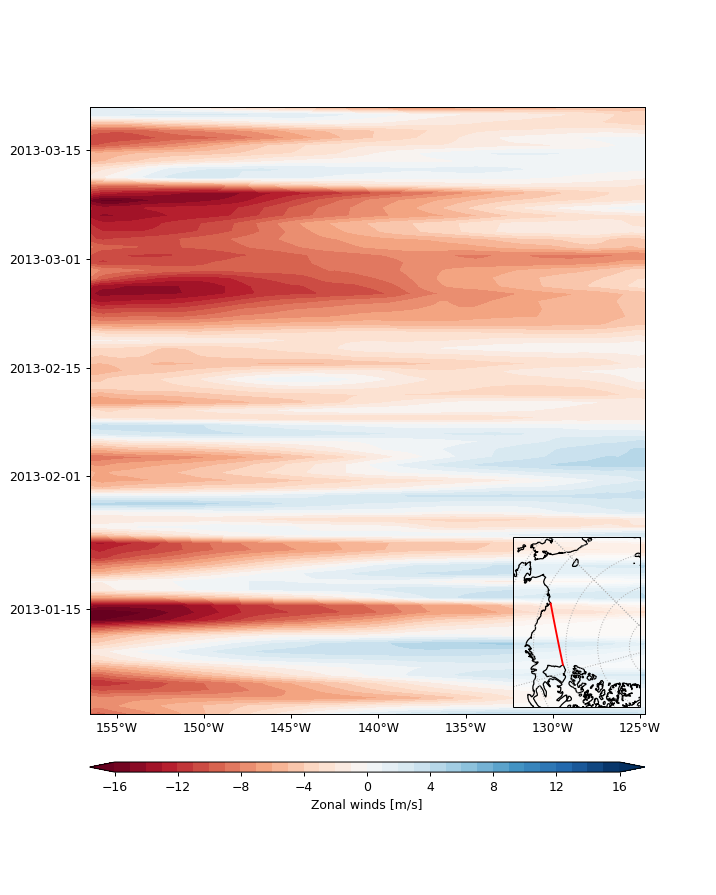

In [134]:
# Plot zonal winds 

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.close('all')

fig = plt.figure(1, figsize=(8., 10.))
ax = plt.axes()

clevs=np.arange(-16,17.,1.)

cf = ax.contourf(ucross['longitude'], ucross['time'], ucross['u10'],
                cmap='RdBu', levels=clevs, extend='both')
fig.colorbar(cf, label='Zonal winds [m/s]', orientation='horizontal', fraction=0.05, pad=0.07, aspect=50)

# Format xaxis
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)

# Inset for geographic reference (makes small map)
lons = [start[0], end[0]]
lats = [start[1], end[1]]
# create the projections
proj = ccrs.NorthPolarStereo(central_longitude=-45)
ax_inset = fig.add_axes([0.7, 0.21, 0.21, 0.19], projection=proj)
ax_inset.coastlines(resolution='50m')
ax_inset.gridlines(draw_labels=False, linestyle='dotted')
ax_inset.set_extent([-2611832.880671568, -369765.49428808136, -1058480.3928495955, 1951306.484993737], 
              crs=proj)

# plot scatter points and line between points                                                                              
#ax_inset.scatter(lons, lats, marker='o', c='r', transform=ccrs.PlateCarree())
ax_inset.plot(ucross['longitude'], ucross['latitude'], c='r', zorder=2, transform=ccrs.PlateCarree())

ax_inset.patch.set_alpha(0.5)
plt.show()

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/plots/era5/'
figname = outpath_plots+'Uwind_Transect_20130101-20130320' + '.png'
fig.savefig(figname, dpi=150, bbox_inches='tight') 


<IPython.core.display.Javascript object>


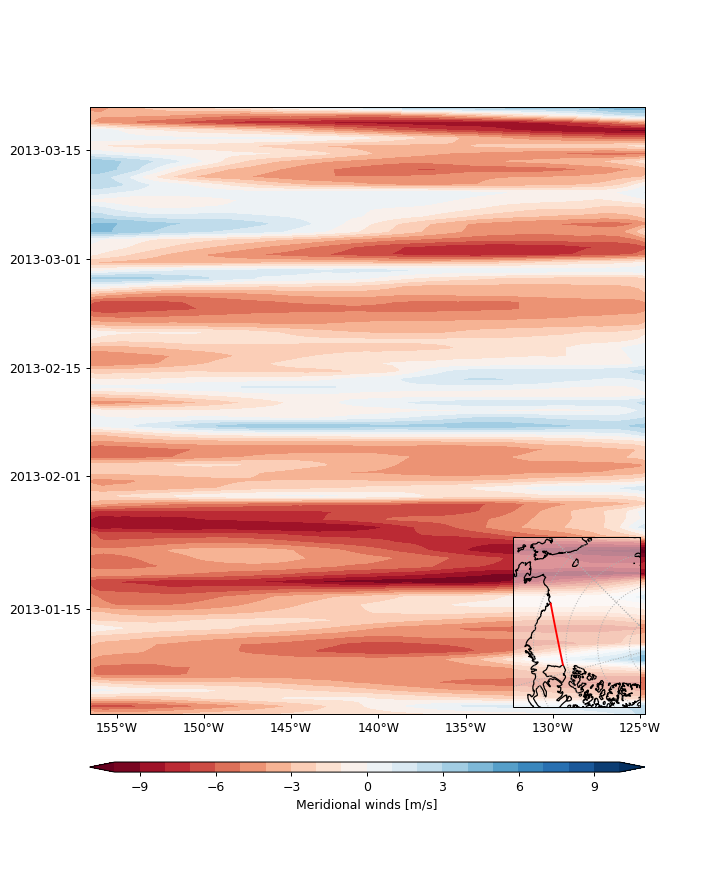

In [136]:
# Plot meridional winds 

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

plt.close('all')

fig = plt.figure(1, figsize=(8., 10.))
ax = plt.axes()

clevs=np.arange(-10,11.,1.)

cf = ax.contourf(vcross['longitude'], vcross['time'], vcross['v10'],
                cmap='RdBu', levels=clevs, extend='both')
fig.colorbar(cf, label='Meridional winds [m/s]', orientation='horizontal', fraction=0.05, pad=0.07, aspect=50)

# Format xaxis
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)

# Inset for geographic reference (makes small map)
lons = [start[0], end[0]]
lats = [start[1], end[1]]

# create the projections
proj = ccrs.NorthPolarStereo(central_longitude=-45)

ax_inset = fig.add_axes([0.7, 0.21, 0.21, 0.19], projection=proj)
ax_inset.coastlines(resolution='50m')
ax_inset.gridlines(draw_labels=False, linestyle='dotted')
ax_inset.set_extent([-2611832.880671568, -369765.49428808136, -1058480.3928495955, 1951306.484993737], 
              crs=proj)

# plot scatter points and line between points                                                                              
ax_inset.scatter(lons, lats, marker='o', c='r', transform=ccrs.PlateCarree())
ax_inset.plot(ucross['longitude'], ucross['latitude'], c='r', zorder=2, transform=ccrs.PlateCarree())

ax_inset.patch.set_alpha(0.5)
plt.show()

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/plots/era5/'
figname = outpath_plots+'Vwind_Transect_20130101-20130320' + '.png'
fig.savefig(figname, dpi=150, bbox_inches='tight') 